# Klasifikasi Supernova Ia Kurva Cahaya Filter g

#### Content:

1. Modules Import
2. Utility Functions
3. Data Import
4. Dataset Review
5. Sampling (RMS & P-value cuts)
6. Preprocessing
    - Normalization
    - Shifting
    - Binarization
    - Linear Interpolation
7. Feature Generation
8. Cross-Validation Method (K-Fold)
9. Models
    - Baseline: Logistic Regression
    - Random Forest
    - Models for a comparison: XGBoost, CatBoost, One-Layer NN
10. Model Evaluation (Random Forest)
    - Table of Scores
    - ROC-Curve
    - Probability Distribution Histogram
    - Features Importance
    - Confusion Matrix Analysis

## Modules Import

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns

import sys

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, make_scorer, f1_score, recall_score, precision_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_score

import copy
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split

from IPython.display import clear_output
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib import cm


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import History 
from keras.utils import plot_model, to_categorical
from keras.optimizers import SGD
import sklearn.metrics as metrics
#from utils import binarization, interpolation, rolling_diff, rolling_ratio, log10_, KFoldsClassifier

from scipy import stats

from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

2024-07-23 23:18:48.595053: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-23 23:18:48.596297: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-23 23:18:48.601057: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-23 23:18:48.647732: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-23 23:18:49.505342: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

## Data Import

In [3]:
data_g = pd.read_csv('TA_Azzidny/DATA/3. Dataset/DATASET_UTAMA_Fix.csv')
data_g = data_g[['objectId','type','is_ia' ,'curve_g', 'nobs_g', 'p_value_g']]
data_g

objectId   type  is_ia  \
0     ZTF17aaaocpq    AGN      0   
1     ZTF17aaapufz    LBV      0   
2     ZTF17aacpbmv  SN Ic      0   
3     ZTF17aadcbei     CV      0   
4     ZTF18aaadtdc    AGN      0   
...            ...    ...    ...   
1489  ZTF24aacxzca  SN II      0   
1490  ZTF24aacyttg  SN Ia      1   
1491  ZTF24aaczgax  SN II      0   
1492  ZTF24aadkwni  SN II      0   
1493  ZTF24aadkwol  SN Ia      1   

                                                curve_g  nobs_g     p_value_g  
0     [(2460288.8362616, 0.0012396709687641713, 4.01...      11  2.749327e-09  
1     [(2460103.7360532, 3.2585630369240395e-05, 7.7...       3  3.884547e-89  
2     [(2460253.8133449, 0.00012326112143300953, 1.1...       4  1.702984e-23  
3     [(2459932.8203472, 0.00013909337042157925, 8.7...       3  7.379994e-04  
4     [(2460305.6727894, 0.00022903743292233798, 1.5...      23  8.910281e-83  
...                                                 ...     ...           ...  
1489  [(2460341.7677894, 0.00016516038538454968, 1.3...       1           NaN  
1490  [(2460326.9902894, 4.19475212400129e-05, 6.938...       1           NaN  
1491  [(2460327.0398727, 0.00013163942908967044, 1.5...       2  1.386096e-28  
1492  [(2460335.9242014, 0.00032826599372755034, 1.9...       1           NaN  
1493  [(2460335.9242014, 0.0009687826506244948, 3.13...       1           NaN  

[1494 rows x 6 columns]

In [4]:
data_g.shape

(1494, 6)

In [5]:
not_ia_share = data_g[data_g.is_ia == 0].shape[0] / data_g.shape[0]
ia_share = data_g[data_g.is_ia == 1].shape[0] / data_g.shape[0]

print("Not-Ia: {0:.2%}\nIa: {1:.2%}".format(not_ia_share, ia_share))


Not-Ia: 45.45%
Ia: 54.55%


## Preprocessing (4 Steps)

In [6]:
import numpy as np

def binarization(x, y, n=10, x_ranges=[0, 100]):
    x = np.array(x)  # Convert list to numpy array
    y = np.array(y)  # Convert list to numpy array
    
    new_y = []
    bins = np.linspace(x_ranges[0], x_ranges[1], n + 1)
    for i_bin in range(n):
        left = bins[i_bin]
        right = bins[i_bin + 1]
        y_sel = y[(x >= left) & (x < right)]
        ay = 0
        if len(y_sel) != 0:
            ay = np.mean(y_sel)
        new_y.append(ay)
    
    return new_y



def interpolation(x, y):
    
    y_iter = np.zeros(len(y))
    
    for i1 in range(len(x)-1):
        if y[i1] != 0:
            break
            
    for i2 in range(i1+1, len(x)):

        if y[i2] == 0:
            continue

        k = (y[i2] - y[i1]) / ((x[i2] - x[i1]))
        b = y[i2] - k * x[i2]

        for i in range(i1, i2+1):
            y_iter[i] = k * x[i] + b

        i1 = i2
        
    return y_iter

def rolling_diff(x):
    
    x_roll = np.zeros(len(x))
    for i in range(1, len(x)):
        x_roll[i] = x[i] - x[i-1]
        
    return x_roll


def rolling_ratio(x):
    
    x_roll = np.zeros(len(x))
    for i in range(1, len(x)):
        if x[i-1] != 0:
            x_roll[i] = x[i] / x[i-1]
        
    return x_roll

def log10_(x):
    
    x_roll = np.zeros(len(x))
    for i in range(0, len(x)):
        if x[i] != 0:
            x_roll[i] = np.log10(x[i])
        
    return x_roll

def get_bin_curves(row):
    aname = row.sn_name
    atype = row.type
    asize = row.size_r
    acurve = row.curve_r
    aline = []


    y_cor = acurve.y / acurve.y.max()
    x_cor = (acurve.x - acurve.x.min())
    x_cor = (acurve.x - acurve.x[y_cor.argmax()])

    new_y = binarization(x_cor, y_cor, n=16, x_ranges=[-50, 100])
    new_y = interpolation(np.arange(len(new_y)), new_y)
    #new_y = rolling_diff(new_y)
    new_y2 = rolling_ratio(new_y)
    # new_y2 = log10_(new_y2)
        
    aline += list(new_y) + list(new_y2) + [is_ia, row.name]
    return aline

class KFoldsClassifier(object):
    
    def __init__(self, classifier, n_splits=2, random_state=None, shuffle=False):
        import copy
        from sklearn.model_selection import StratifiedKFold
        import numpy as np
        self.classifier = classifier
        self.n_splits = n_splits
        self.random_state = random_state
        self.shuffle = shuffle
        
        self.kfold = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
        
        self.fitted_classifiers = []
        self.classifier_test_index = []
        
    def fit(self, X, y, W):
        import copy
        from sklearn.calibration import CalibratedClassifierCV
        from sklearn.model_selection import train_test_split
        
        for train_index, test_index in self.kfold.split(X, y, W):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            W_train, W_test = W[train_index], W[test_index]
            
            X_tr, X_cal, y_tr, y_cal, W_tr, W_cal = train_test_split(X_train, 
                                                                     y_train, 
                                                                     W_train, 
                                                                     test_size=0.33,
                                                                     random_state=42)
            reg = copy.deepcopy(self.classifier)
            reg.fit(X_tr, y_tr, sample_weight=W_tr)
            calibrator = CalibratedClassifierCV(reg, cv='prefit', method='sigmoid')
            calibrator.fit(X_cal, y_cal, sample_weight=W_cal)
            self.fitted_classifiers.append(calibrator)
            self.classifier_test_index.append(test_index)
            
    def fit_for_tune(self, X, y, W):
        import copy
        from sklearn.calibration import CalibratedClassifierCV
        from sklearn.model_selection import train_test_split
        
        for train_index, test_index in self.kfold.split(X, y, W):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            W_train, W_test = W[train_index], W[test_index]
            
            X_tr, X_cal, y_tr, y_cal, W_tr, W_cal = train_test_split(X_train, 
                                                                     y_train, 
                                                                     W_train, 
                                                                     test_size=0.33,
                                                                     random_state=42)
            reg = copy.deepcopy(self.classifier)
            reg.fit(X_tr, y_tr, sample_weight=W_tr)
            calibrator = CalibratedClassifierCV(reg, cv='prefit', method='sigmoid')
            calibrator.fit(X_cal, y_cal, sample_weight=W_cal)
            return calibrator
            
    def predict_test_sample(self, X):
        y_pred = np.zeros(len(X))
        predictions = []
        for reg, test_index in zip(self.fitted_classifiers, self.classifier_test_index):
            y_pred[test_index] = reg.predict_proba(X[test_index])[:,1]
        return y_pred
    
    def predict(self, X):
        predictions = []
        for reg in self.fitted_classifiers:
            predictions.append(reg.predict(X))
        print(np.mean(predictions, axis=0))
        return np.mean(predictions, axis=0)

#### Normalization (Step 1)

In [7]:
import ast
def parse_curve(curve_str):
    """Parse the string representation of a curve."""
    return ast.literal_eval(curve_str)

def normalization(curve):
    """Normalize the y-values in a curve and return them as a list of floats."""
    curve = parse_curve(curve)
    if not curve:  # Check if the curve is empty
        return []
    y_values = [point[1] for point in curve]
    if not y_values:  # Check if there are no y-values
        return []
    max_y = max(y_values)
    if max_y == 0:  # Avoid division by zero
        return [0 for y in y_values]
    normalized_y_values = [y / max_y for y in y_values]
    return normalized_y_values
def normalize_curve_g(row):
    row['curve_g_normalized'] = normalization(row['curve_g'])
    return row

data_g = data_g.apply(normalize_curve_g, axis=1)

#### Shifting (Step 2)

In [8]:

def shifting_curve_g(row):
    curve_g = parse_curve(row['curve_g'])
    if not curve_g:
        return []
    x_values = [point[0] for point in curve_g]
    y_normed = row['curve_g_normalized']
    max_index = np.argmax(y_normed)  # Get the index of the max y-value in the normalized curve
    x_shifted = [x - x_values[max_index] for x in x_values]
    return x_shifted

data_g['x_shifted_g'] = data_g.apply(shifting_curve_g, axis=1)

#### Binarization (Step 3)

In [9]:

def get_bins_g(row):
    return binarization(row['x_shifted_g'], row['curve_g_normalized'], n=16, x_ranges=[-50, 100])

data_g['binarized_g'] = data_g.apply(get_bins_g, axis=1)

#### Linear Interpolation (Step 4)

In [10]:
def interpolate_g(row):
    x_indices = np.arange(len(row['binarized_g']))
    return interpolation(x_indices, row['binarized_g'])

data_g['interpolated_g'] = data_g.apply(interpolate_g, axis=1)

In [11]:
data_g

objectId   type  is_ia  \
0     ZTF17aaaocpq    AGN      0   
1     ZTF17aaapufz    LBV      0   
2     ZTF17aacpbmv  SN Ic      0   
3     ZTF17aadcbei     CV      0   
4     ZTF18aaadtdc    AGN      0   
...            ...    ...    ...   
1489  ZTF24aacxzca  SN II      0   
1490  ZTF24aacyttg  SN Ia      1   
1491  ZTF24aaczgax  SN II      0   
1492  ZTF24aadkwni  SN II      0   
1493  ZTF24aadkwol  SN Ia      1   

                                                curve_g  nobs_g     p_value_g  \
0     [(2460288.8362616, 0.0012396709687641713, 4.01...      11  2.749327e-09   
1     [(2460103.7360532, 3.2585630369240395e-05, 7.7...       3  3.884547e-89   
2     [(2460253.8133449, 0.00012326112143300953, 1.1...       4  1.702984e-23   
3     [(2459932.8203472, 0.00013909337042157925, 8.7...       3  7.379994e-04   
4     [(2460305.6727894, 0.00022903743292233798, 1.5...      23  8.910281e-83   
...                                                 ...     ...           ...   
1489  [(2460341.7677894, 0.00016516038538454968, 1.3...       1           NaN   
1490  [(2460326.9902894, 4.19475212400129e-05, 6.938...       1           NaN   
1491  [(2460327.0398727, 0.00013163942908967044, 1.5...       2  1.386096e-28   
1492  [(2460335.9242014, 0.00032826599372755034, 1.9...       1           NaN   
1493  [(2460335.9242014, 0.0009687826506244948, 3.13...       1           NaN   

                                     curve_g_normalized  \
0     [0.9456277641393303, 0.7894412104271048, 0.860...   
1       [0.06830301111901348, 0.25592927393777987, 1.0]   
2     [0.4363948413793137, 0.825125346201451, 0.9416...   
3         [1.0, 0.8426361874637625, 0.6721706622728975]   
4     [0.6761452135940874, 0.754813502838174, 1.0, 0...   
...                                                 ...   
1489                                              [1.0]   
1490                                              [1.0]   
1491                         [0.31968300098924995, 1.0]   
1492                                              [1.0]   
1493                                              [1.0]   

                                            x_shifted_g  \
0     [-7.097951400093734, -5.067060200031847, -3.15...   
1       [-14.033703700173646, -12.047928200103343, 0.0]   
2     [-8.019803199917078, -3.961006899829954, -1.97...   
3            [0.0, 2.08494219975546, 4.009293999988586]   
4     [-8.950486099813133, -6.992615799885243, 0.0, ...   
...                                                 ...   
1489                                              [0.0]   
1490                                              [0.0]   
1491                          [-8.882430499885231, 0.0]   
1492                                              [0.0]   
1493                                              [0.0]   

                                            binarized_g  \
0     [0, 0, 0, 0, 0.8648794348059475, 0.89972177971...   
1     [0, 0, 0, 0.06830301111901348, 0.2559292739377...   
2     [0, 0, 0, 0, 0.6307600937903823, 0.97081469467...   
3     [0, 0, 0, 0, 0, 0.8382689499122199, 0, 0, 0, 0...   
4     [0, 0, 0, 0, 0.7154793582161307, 1.0, 0.747342...   
...                                                 ...   
1489  [0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
1490  [0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
1491  [0, 0, 0, 0, 0.31968300098924995, 1.0, 0, 0, 0...   
1492  [0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
1493  [0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   

                                         interpolated_g  
0     [0.0, 0.0, 0.0, 0.0, 0.8648794348059475, 0.899...  
1     [0.0, 0.0, 0.0, 0.06830301111901349, 0.2559292...  
2     [0.0, 0.0, 0.0, 0.0, 0.6307600937903823, 0.970...  
3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4     [0.0, 0.0, 0.0, 0.0, 0.7154793582161307, 1.0, ...  
...                                                 ...  
1489  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1490  [0.0, 0

In [12]:
data = data_g[(data_g.p_value_g < 0.001) & (data_g.nobs_g >= 4)].reset_index()

In [13]:
data.shape

(975, 11)

In [14]:
print("Selected Ia: ", len(data[data.is_ia == 1]))
print("Selected Not-Ia: ", len(data[data.is_ia == 0]))

Selected Ia:  566
Selected Not-Ia:  409


#### Results SN Ia

In [15]:
data.head()

index      objectId   type  is_ia  \
0      0  ZTF17aaaocpq    AGN      0   
1      2  ZTF17aacpbmv  SN Ic      0   
2      4  ZTF18aaadtdc    AGN      0   
3      5  ZTF18aaakpsa    AGN      0   
4      6  ZTF18aaaniwu    AGN      0   

                                             curve_g  nobs_g      p_value_g  \
0  [(2460288.8362616, 0.0012396709687641713, 4.01...      11   2.749327e-09   
1  [(2460253.8133449, 0.00012326112143300953, 1.1...       4   1.702984e-23   
2  [(2460305.6727894, 0.00022903743292233798, 1.5...      23   8.910281e-83   
3  [(2460143.9193866, 0.0005129869977513433, 2.28...      36  3.422934e-211   
4  [(2459842.9687384, 6.761233642148255e-05, 1.05...      21  1.098845e-144   

                                  curve_g_normalized  \
0  [0.9456277641393303, 0.7894412104271048, 0.860...   
1  [0.4363948413793137, 0.825125346201451, 0.9416...   
2  [0.6761452135940874, 0.754813502838174, 1.0, 0...   
3  [0.29999927746387833, 0.27201951825061327, 0.2...   
4  [0.09921101801658061, 0.11203659305535388, 0.1...   

                                         x_shifted_g  \
0  [-7.097951400093734, -5.067060200031847, -3.15...   
1  [-8.019803199917078, -3.961006899829954, -1.97...   
2  [-8.950486099813133, -6.992615799885243, 0.0, ...   
3  [-21.969756899867207, -16.933900400064886, -14...   
4  [-446.9157639001496, -442.8917592000216, -440....   

                                         binarized_g  \
0  [0, 0, 0, 0, 0.8648794348059475, 0.89972177971...   
1  [0, 0, 0, 0, 0.6307600937903823, 0.97081469467...   
2  [0, 0, 0, 0, 0.7154793582161307, 1.0, 0.747342...   
3  [0, 0.24452325026708596, 0.2818404969571977, 0...   
4  [0, 0, 0, 0, 0, 0.28958682807529434, 0, 0, 0, ...   

                                      interpolated_g  
0  [0.0, 0.0, 0.0, 0.0, 0.8648794348059475, 0.899...  
1  [0.0, 0.0, 0.0, 0.0, 0.6307600937903823, 0.970...  
2  [0.0, 0.0, 0.0, 0.0, 0.7154793582161307, 1.0, ...  
3  [0.0, 0.24452325026708596, 0.2818404969571977,...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

## Features Generation

In [16]:
def generate_features_g(row):
    return rolling_ratio(row['interpolated_g'])

data['rolling_ratios_g'] = data.apply(generate_features_g, axis=1)

In [17]:
init_features = np.stack(data.interpolated_g.values)
generated_features = np.stack(data.rolling_ratios_g.values)
print('Length of the initial vector:', init_features[0].shape[0])
print('Length of the generated vector:', generated_features[0].shape[0])

Length of the initial vector: 16
Length of the generated vector: 16


In [18]:
features_df = pd.DataFrame(np.concatenate((init_features, generated_features), axis=1))
features_df.columns = ['x_' + str(i) for i in range(16)] + ['d_' + str(i) for i in range(16)]
features_df

x_0       x_1      x_2       x_3       x_4       x_5       x_6       x_7  \
0    0.0  0.000000  0.00000  0.000000  0.864879  0.899722  0.000000  0.000000   
1    0.0  0.000000  0.00000  0.000000  0.630760  0.970815  0.000000  0.000000   
2    0.0  0.000000  0.00000  0.000000  0.715479  1.000000  0.747343  0.000000   
3    0.0  0.244523  0.28184  0.265158  0.307230  1.000000  0.086856  0.113004   
4    0.0  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000   
..   ...       ...      ...       ...       ...       ...       ...       ...   
970  0.0  0.000000  0.00000  0.000000  0.933598  0.965897  0.637819  0.309742   
971  0.0  0.000000  0.00000  0.000000  0.356911  0.915037  0.262882  0.160635   
972  0.0  0.000000  0.00000  0.000000  0.650262  0.995234  0.000000  0.000000   
973  0.0  0.000000  0.00000  0.000000  0.000000  1.000000  0.616108  0.286734   
974  0.0  0.000000  0.00000  0.000000  0.504800  0.971552  0.672556  0.373560   

          x_8       x_9  ...       d_6       d_7       d_8       d_9     d_10  \
0    0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000  0.00000   
1    0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000  0.00000   
2    0.000000  0.000000  ...  0.747343  0.000000  0.000000  0.000000  0.00000   
3    0.242217  0.271595  ...  0.086856  1.301045  2.143447  1.121286  1.03144   
4    0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000  0.00000   
..        ...       ...  ...       ...       ...       ...       ...      ...   
970  0.000000  0.000000  ...  0.660339  0.485626  0.000000  0.000000  0.00000   
971  0.000000  0.000000  ...  0.287291  0.611055  0.000000  0.000000  0.00000   
972  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000  0.00000   
973  0.144344  0.000000  ...  0.616108  0.465397  0.503408  0.000000  0.00000   
974  0.000000  0.000000  ...  0.692249  0.555433  0.000000  0.000000  0.00000   

         d_11      d_12     d_13      d_14  d_15  
0    0.000000  0.000000  0.00000  0.000000   0.0  
1    0.000000  0.000000  0.00000  0.000000   0.0  
2    0.000000  0.000000  0.00000  0.000000   0.0  
3    1.062849  0.702886  0.89863  0.920466   0.0  
4    0.000000  0.000000  0.00000  0.000000   0.0  
..        ...       ...      ...       ...   ...  
970  0.000000  0.000000  0.00000  0.000000   0.0  
971  0.000000  0.000000  0.00000  0.000000   0.0  
972  0.000000  0.000000  0.00000  0.000000   0.0  
973  0.000000  0.000000  0.00000  0.000000   0.0  
974  0.000000  0.000000  0.00000  0.000000   0.0  

[975 rows x 32 columns]

In [19]:
data = pd.concat([data.reset_index(drop=True), features_df.reset_index(drop=True)], axis=1)

In [21]:
X = data.loc[:, 'x_0':'d_15'].values
y = data['is_ia'].values
indices = np.arange(data.shape[0])

## Cross-Validation Method (K-Fold)

In [22]:
def kfold(clf, X, y, clf_name='any'):
    cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
    results = pd.DataFrame(columns=['training_score', 'test_score'])
    predictions = []
    test_indices = []
    
    for (train, test), i in zip(cv.split(X, y), range(5)):
        if clf_name == 'nn':
            clf.fit(X[train], y[train], epochs=50, validation_split=0.1, verbose=0)
            y_pred = clf.predict(X[test]).flatten()
        else:
            clf.fit(X[train], y[train])
            if hasattr(clf, 'predict_proba'):
                y_pred = clf.predict_proba(X[test])[:, 1]
            else:
                y_pred = clf.predict(X[test])
        predictions.append(y_pred)
        test_indices.append(test)
        
    return predictions, test_indices

In [23]:
def get_predictions(X, predictions, test_indices):
    results = pd.DataFrame(columns=['index', 'y_pred'])
    results['index'] = np.arange(X.shape[0])
    for i, (pred, ind) in enumerate(zip(predictions, test_indices)):
        results.loc[ind, 'y_pred'] = pred
    return results['y_pred'].values

## Models SN Ia

#### Baseline: Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
logreg= LogisticRegression(penalty='l2',
                            random_state=42,
                            solver='lbfgs',
                            max_iter=1000)

predictions, test_indices = kfold(logreg, X, y)

In [25]:
data['logreg_pred_ia'] = get_predictions(X, predictions, test_indices)

#### Random Forest

In [26]:

rf = RandomForestClassifier(n_estimators=800,
                            min_samples_split=10, 
                            min_samples_leaf=2, 
                            max_features='sqrt',
                            bootstrap=True, 
                            max_depth=12, 
                            n_jobs=4, 
                            random_state=25)

predictions, test_indices = kfold(rf, X, y)

In [27]:
data['rf_pred_ia'] = get_predictions(X, predictions, test_indices)

#### XGBoost

In [28]:
xgb = XGBClassifier(n_estimators=500, 
                    learning_rate=0.02, 
                    max_depth=6, 
                    subsample=0.8, 
                    colsample_bytree=0.7, 
                    min_child_weight=1, 
                    n_jobs=3)

predictions, test_indices = kfold(xgb, X, y)

In [29]:
data['xgb_pred_ia'] = get_predictions(X, predictions, test_indices)

#### Neural Network

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()
    
    # First hidden layer
model.add(Dense(128, activation='relu', input_dim=X.shape[1]))
model.add(Dropout(0.3))  # Adding dropout to prevent overfitting
    
    # Second hidden layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
    
    # Third hidden layer
model.add(Dense(32, activation='relu'))
    
    # Output layer
model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])


predictions, test_indices = kfold(model, X, y, 'nn')

/mgpfs/home/aamin/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step


In [31]:
data['nn_ia'] = get_predictions(X, predictions, test_indices)

## Model Evaluation

#### Table of Scores SN Ia

In [32]:
ia_columns = data.loc[:, 'logreg_pred_ia':'nn_ia'].columns

# Inisialisasi dictionary untuk menyimpan skor
scores_dict_ia = {}

# Loop melalui setiap kolom yang dipilih
for model_pred_ia in ia_columns:
    y_pred = data[model_pred_ia].values
    try:
        # Ensure that `data.is_ia` contains valid binary values
        y_true = data['is_ia'].values
        assert np.all(np.isin(y_true, [0, 1])), "Invalid values in data.is_ia"
        assert y_pred.ndim == 1, "y_pred should be a 1-dimensional array"
        
        auc = roc_auc_score(y_true, y_pred)
        acc = accuracy_score(y_true, y_pred >= 0.5)
        f1 = f1_score(y_true, y_pred >= 0.5)
        pr = precision_score(y_true, y_pred >= 0.5)
        rec = recall_score(y_true, y_pred >= 0.5)
        
        scores_dict_ia[model_pred_ia] = [auc, acc, f1, pr, rec]
    except ValueError as e:
        print(f"Error processing {model_pred_ia}: {e}")
    except AssertionError as e:
        print(f"AssertionError for {model_pred_ia}: {e}")

In [33]:
scores_ia = pd.DataFrame(scores_dict_ia)
scores_ia['score'] = ['AUC', 'Acc', 'F1-score', 'Precision', 'Recall']
scores_ia.set_index('score')

logreg_pred_ia  rf_pred_ia  xgb_pred_ia     nn_ia
score                                                       
AUC              0.824859    0.878442     0.863104  0.885008
Acc              0.792821    0.820513     0.812308  0.834872
F1-score         0.838400    0.852817     0.845047  0.865721
Precision        0.766082    0.813804     0.811382  0.819905
Recall           0.925795    0.895760     0.881625  0.916961

In [34]:
# Inisialisasi dictionary untuk menyimpan kesalahan standar
std_errors_ia = {}

# Loop melalui setiap kolom yang dipilih
for model_pred_ia in ia_columns:
    bs_auc = []
    bs_acc = []
    bs_f1 = []
    bs_pr = []
    bs_rec = []
    for i in range(1000):
        idx = np.random.choice([i for i in range(data.shape[0])], data.shape[0])
        bs_y_test = data.is_ia.values[idx]
        bs_y_pred = data[model_pred_ia].values[idx]
        bs_auc.append(roc_auc_score(bs_y_test, bs_y_pred))
        bs_acc.append(accuracy_score(bs_y_test, bs_y_pred >= 0.5))
        bs_f1.append(f1_score(bs_y_test, bs_y_pred >= 0.5))
        bs_pr.append(precision_score(bs_y_test, bs_y_pred >= 0.5))
        bs_rec.append(recall_score(bs_y_test, bs_y_pred >= 0.5))
        
    std_errors_ia[model_pred_ia] = [np.std(bs_auc), np.std(bs_acc), np.std(bs_f1), np.std(bs_pr), np.std(bs_rec)]
    print('Done ' + model_pred_ia)

Done logreg_pred_ia
Done rf_pred_ia
Done xgb_pred_ia
Done nn_ia


In [35]:
errs_ia = pd.DataFrame(std_errors_ia)
errs_ia.index = ['AUC', 'Acc', 'F1-score', 'Precision', 'Recall']
errs_ia

logreg_pred_ia  rf_pred_ia  xgb_pred_ia     nn_ia
AUC              0.014983    0.011648     0.012047  0.010955
Acc              0.013064    0.012064     0.012728  0.011573
F1-score         0.011359    0.010757     0.011514  0.010099
Precision        0.016107    0.015367     0.015681  0.014922
Recall           0.011448    0.012564     0.013968  0.011806

#### Confusion Matrix

In [36]:
from sklearn.metrics import confusion_matrix
tn_ia, fp_ia, fn_ia, tp_ia = confusion_matrix(data.is_ia.values, data['nn_ia'].values >= 0.5).ravel()

(tn_ia, fp_ia, fn_ia, tp_ia)

(295, 114, 47, 519)

In [37]:
tn_ia, fp_ia, fn_ia, tp_ia = confusion_matrix(data.is_ia.values, data['xgb_pred_ia'].values >= 0.5).ravel()

(tn_ia, fp_ia, fn_ia, tp_ia)

(293, 116, 67, 499)

In [38]:
tn_ia, fp_ia, fn_ia, tp_ia = confusion_matrix(data.is_ia.values, data['rf_pred_ia'].values >= 0.5).ravel()

(tn_ia, fp_ia, fn_ia, tp_ia)

(293, 116, 59, 507)

In [39]:
tn_ia, fp_ia, fn_ia, tp_ia = confusion_matrix(data.is_ia.values, data['logreg_pred_ia'].values >= 0.5).ravel()

(tn_ia, fp_ia, fn_ia, tp_ia)

(249, 160, 42, 524)

### ROC Curve

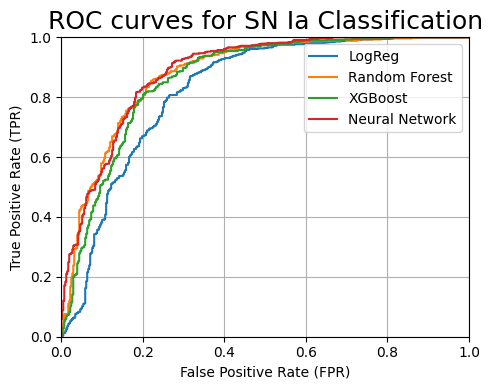

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

models = ['LogReg', 'Random Forest', 'XGBoost', 'Neural Network']

ax.set_ylabel('True Positive Rate (TPR)')
ax.set_xlabel('False Positive Rate (FPR)')
ax.set_xlim(0., 1)
ax.set_ylim(0., 1)
ax.set_title('ROC curves for SN Ia Classification', fontsize=18)
ax.grid(visible=True)

colors = ['C0', 'C1', 'C2', 'C3']

for i, model_pred in enumerate(data.loc[:, 'logreg_pred_ia':'nn_ia'].columns):
    y_pred = data[model_pred].values
    fpr, tpr, thresholds = roc_curve(data['is_ia'], y_pred)
    ax.plot(fpr, tpr, linewidth=1.5, label=models[i], color=colors[i])
    
ax.legend()

plt.tight_layout()
#plt.savefig(fname='Gambar/roc_curves_ia.pdf', format='pdf')
plt.show()

In [41]:
y_pred_ia = data['nn_ia'].values
y_true_ia = data.is_ia.values

auc_ia = roc_auc_score(y_true_ia, y_pred_ia)
print(f"ROC AUC: {auc_ia}")

ROC AUC: 0.8850078187771604


#### Probablity Distribution Histogram untuk SN Ia

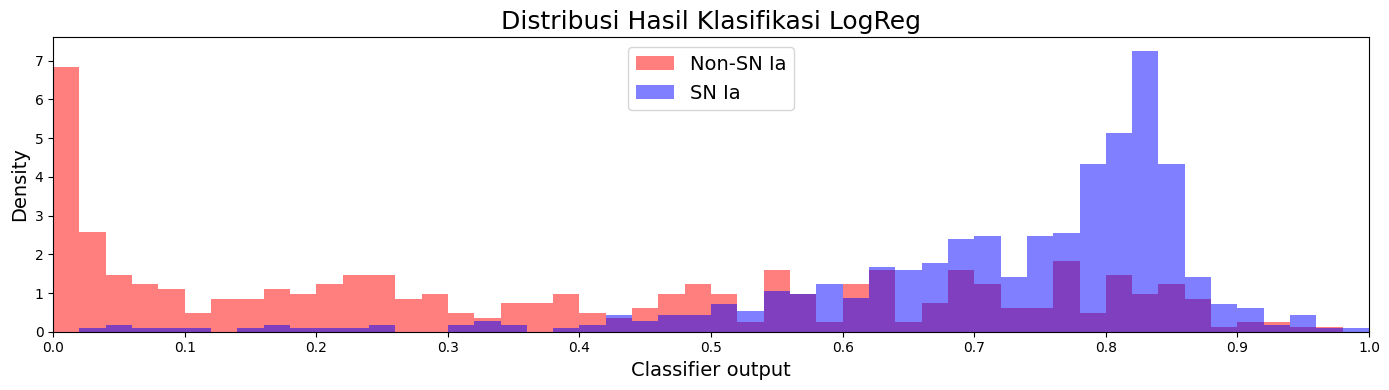

In [42]:
y_pred_ia = data['logreg_pred_ia'].values

fig, ax = plt.subplots(figsize=(14, 4))

plt.tight_layout()

ax.set_title('Distribusi Hasil Klasifikasi LogReg', fontsize=18)
ax.set_xticks(np.linspace(0, 1, 11))
ax.set_xlabel('Classifier output', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.hist(y_pred_ia[data.is_ia.values == 0].reshape(-1, 1), 
        bins=np.linspace(0, 1, 51), 
        density=True, 
        label='Non-SN Ia', 
        color='r', alpha=0.5)
ax.hist(y_pred_ia[data.is_ia.values == 1].reshape(-1, 1), 
        bins=np.linspace(0, 1, 51), 
        density=True, 
        label='SN Ia', 
        color='b', 
        alpha=0.5)
ax.legend(loc='upper center', fontsize=14)
ax.set_xlim(0., 1)

plt.tight_layout()
#plt.savefig(fname='images/prob_dist_ia.pdf', format='pdf')
plt.show()


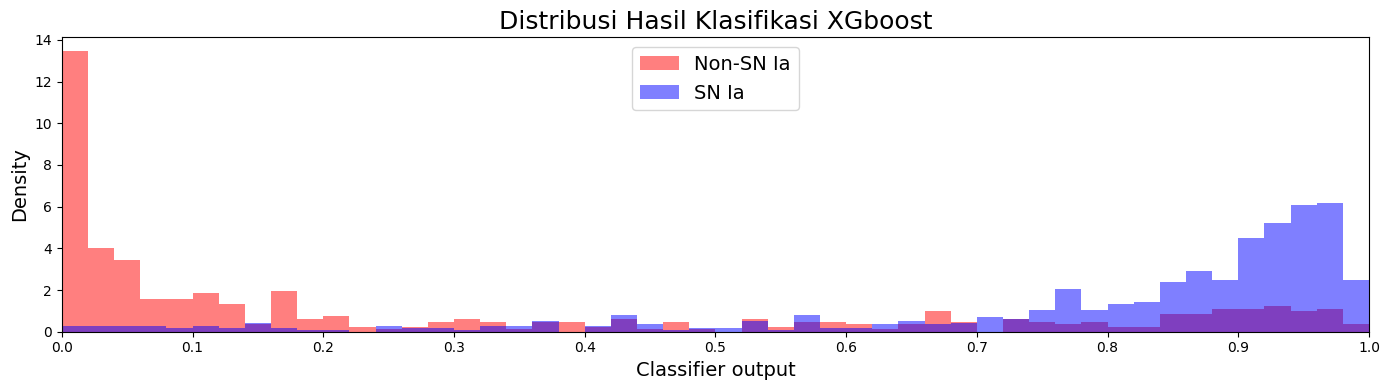

In [43]:
y_pred_ia = data['xgb_pred_ia'].values

fig, ax = plt.subplots(figsize=(14, 4))

plt.tight_layout()

ax.set_title('Distribusi Hasil Klasifikasi XGboost', fontsize=18)
ax.set_xticks(np.linspace(0, 1, 11))
ax.set_xlabel('Classifier output', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.hist(y_pred_ia[data.is_ia.values == 0].reshape(-1, 1), 
        bins=np.linspace(0, 1, 51), 
        density=True, 
        label='Non-SN Ia', 
        color='r', alpha=0.5)
ax.hist(y_pred_ia[data.is_ia.values == 1].reshape(-1, 1), 
        bins=np.linspace(0, 1, 51), 
        density=True, 
        label='SN Ia', 
        color='b', 
        alpha=0.5)
ax.legend(loc='upper center', fontsize=14)
ax.set_xlim(0., 1)

plt.tight_layout()
#plt.savefig(fname='images/prob_dist_ia.pdf', format='pdf')
plt.show()


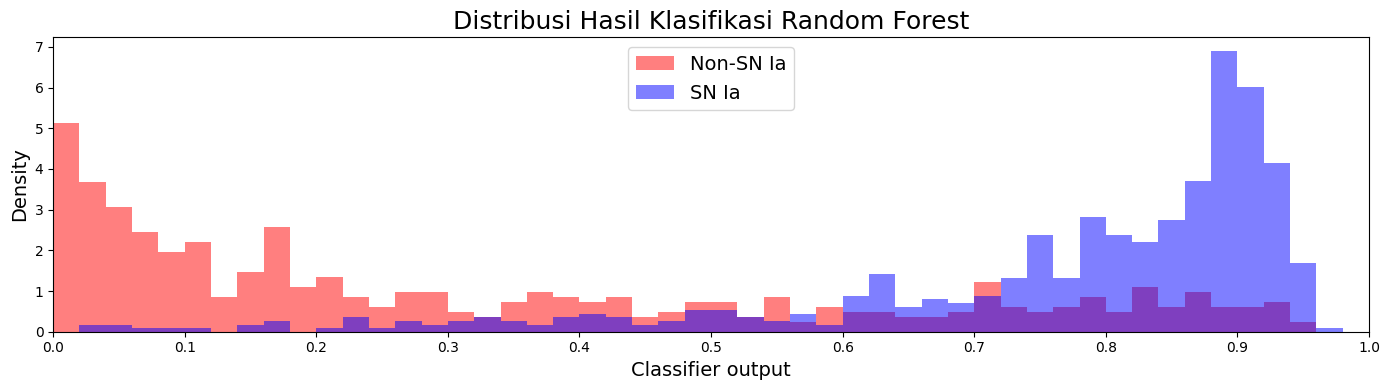

In [44]:
y_pred_ia = data['rf_pred_ia'].values

fig, ax = plt.subplots(figsize=(14, 4))

plt.tight_layout()

ax.set_title('Distribusi Hasil Klasifikasi Random Forest', fontsize=18)
ax.set_xticks(np.linspace(0, 1, 11))
ax.set_xlabel('Classifier output', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.hist(y_pred_ia[data.is_ia.values == 0].reshape(-1, 1), 
        bins=np.linspace(0, 1, 51), 
        density=True, 
        label='Non-SN Ia', 
        color='r', alpha=0.5)
ax.hist(y_pred_ia[data.is_ia.values == 1].reshape(-1, 1), 
        bins=np.linspace(0, 1, 51), 
        density=True, 
        label='SN Ia', 
        color='b', 
        alpha=0.5)
ax.legend(loc='upper center', fontsize=14)
ax.set_xlim(0., 1)

plt.tight_layout()
#plt.savefig(fname='images/prob_dist_ia.pdf', format='pdf')
plt.show()


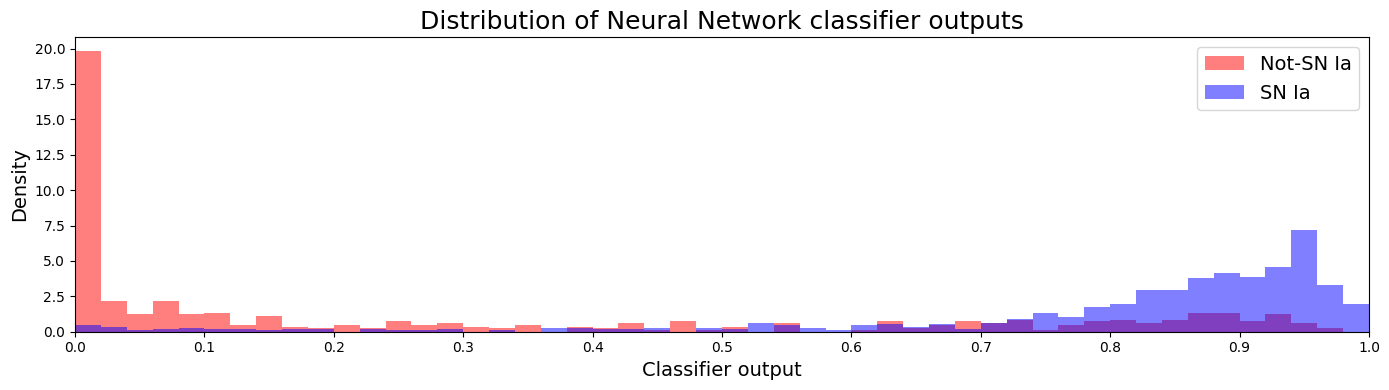

In [45]:
y_pred_ia = data['nn_ia'].values

fig, ax = plt.subplots(figsize=(14, 4))

plt.tight_layout()

ax.set_title('Distribution of Neural Network classifier outputs', fontsize=18)
ax.set_xticks(np.linspace(0, 1, 11))
ax.set_xlabel('Classifier output', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.hist(y_pred_ia[data.is_ia.values == 0].reshape(-1, 1), 
        bins=np.linspace(0, 1, 51), 
        density=True, 
        label='Not-SN Ia', 
        color='r', alpha=0.5)
ax.hist(y_pred_ia[data.is_ia.values == 1].reshape(-1, 1), 
        bins=np.linspace(0, 1, 51), 
        density=True, 
        label='SN Ia', 
        color='b', 
        alpha=0.5)
ax.legend(loc='best', fontsize=14)
ax.set_xlim(0., 1)

plt.tight_layout()
#plt.savefig(fname='images/prob_dist_ia.pdf', format='pdf')
plt.show()


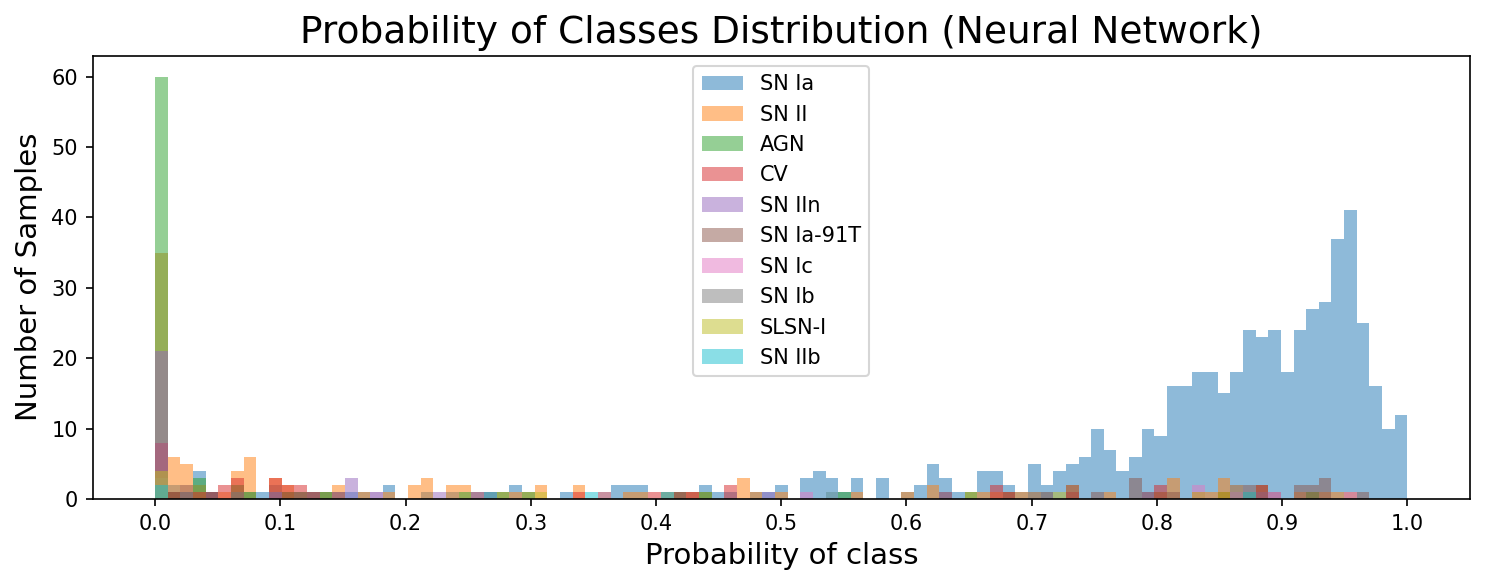

In [46]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=150)

# Memplot distribusi probabilitas untuk setiap jenis yang diklaim dalam data 'is_ia'
for ct in data.type.value_counts().head(10).index:
    fdata = data[data.type == ct].reset_index(drop=True).copy()
    y_pred_ia = fdata['nn_ia'].values

    ax.hist(y_pred_ia.reshape(-1, 1), 
            bins=np.linspace(0, 1, 100), 
            label=ct, alpha=0.5)

ax.legend(loc='best')
ax.set_title('Probability of Classes Distribution (Neural Network)', fontsize=18)
ax.set_xticks(np.linspace(0, 1, 11))
ax.set_xlabel('Probability of class', fontsize=14)
ax.set_ylabel('Number of Samples', fontsize=14)
plt.tight_layout()
#plt.savefig(fname='Gambar/prob_dist_ia.pdf', format='pdf')
plt.show()


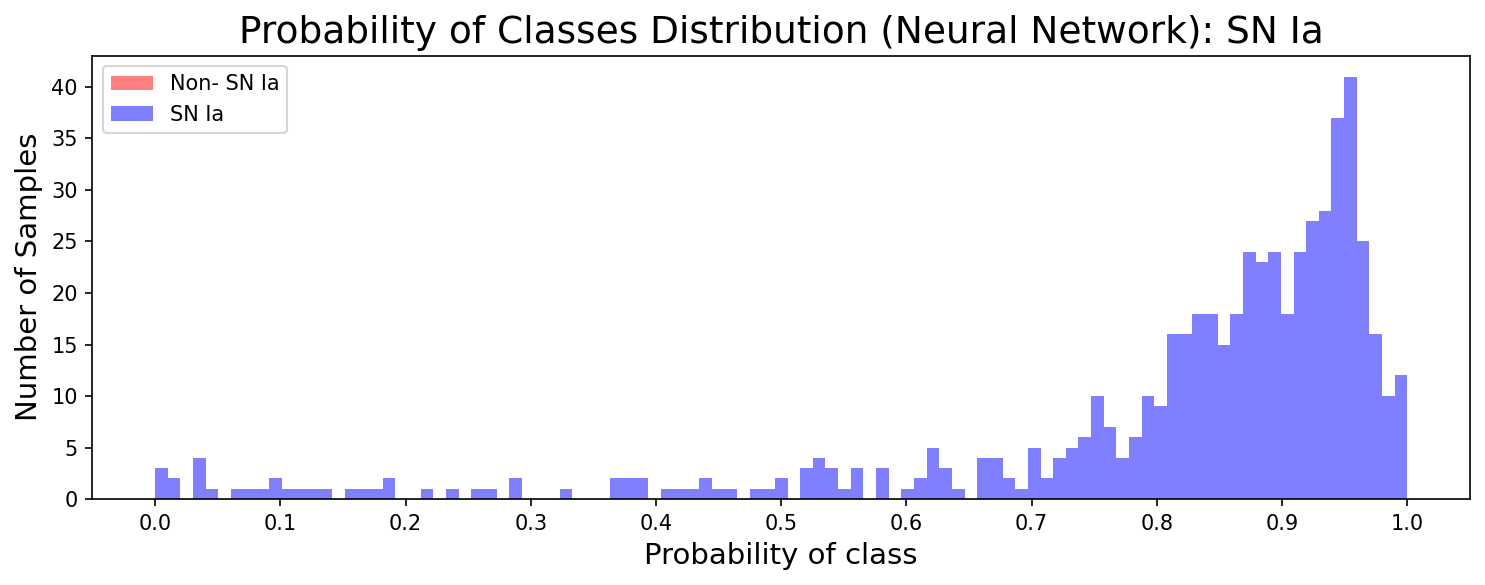

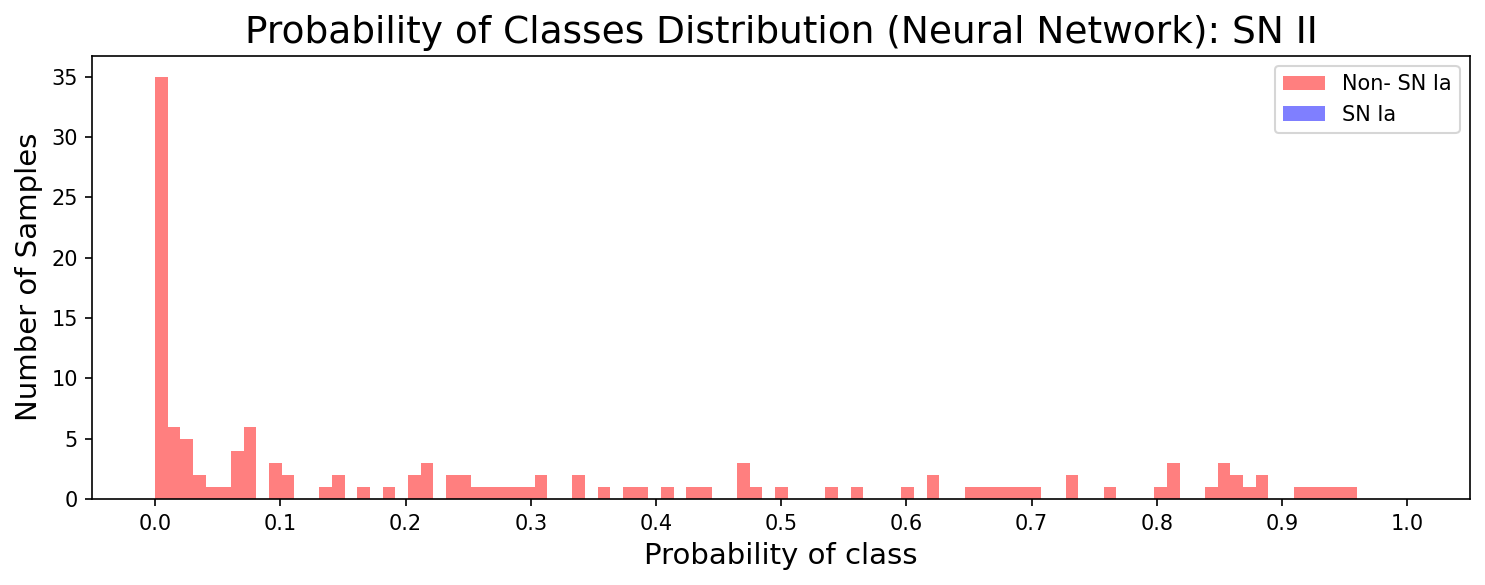

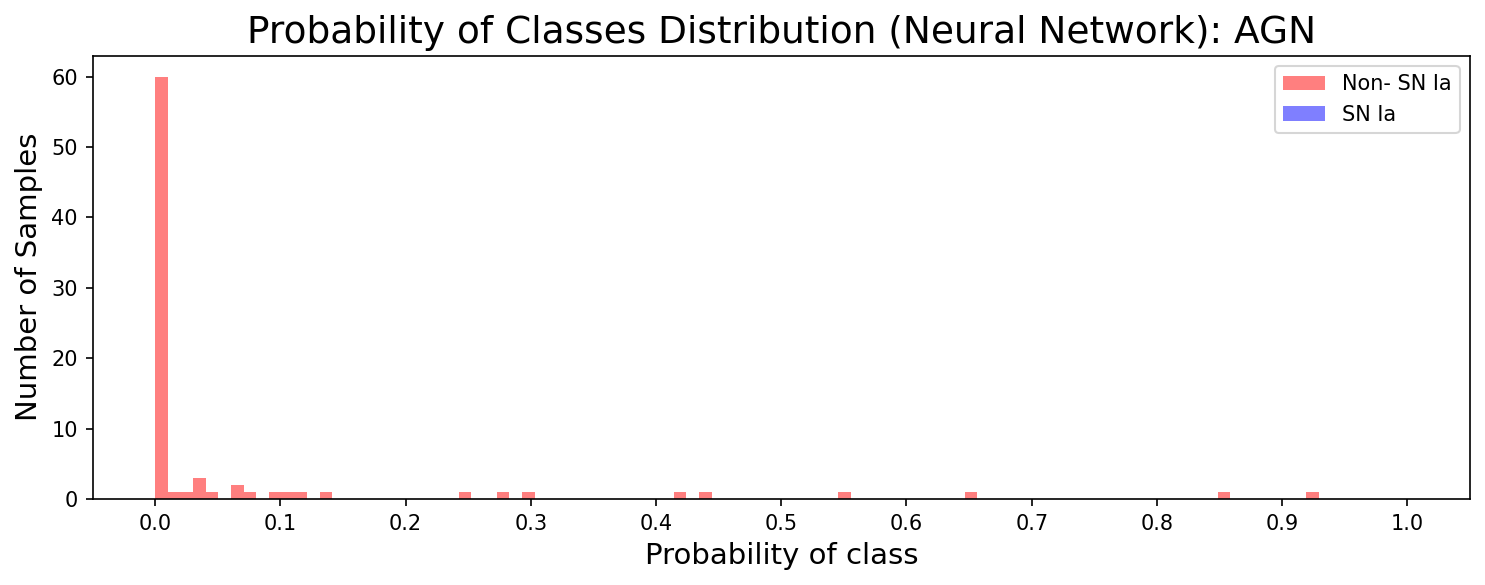

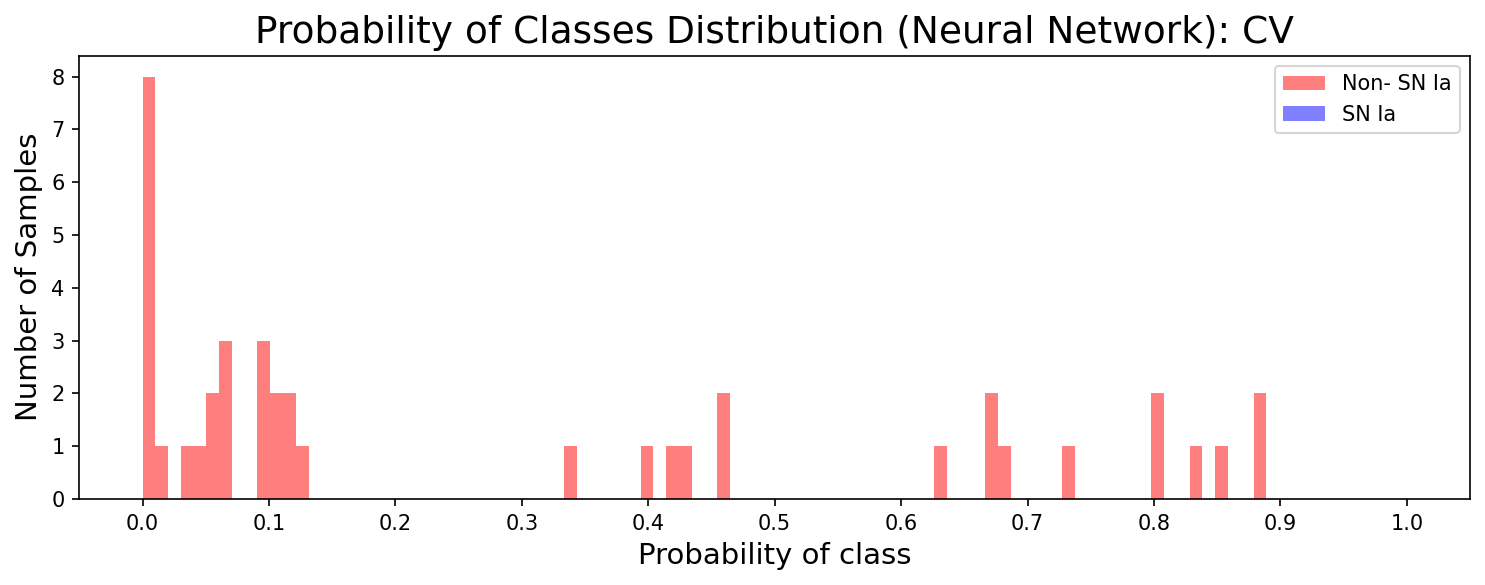

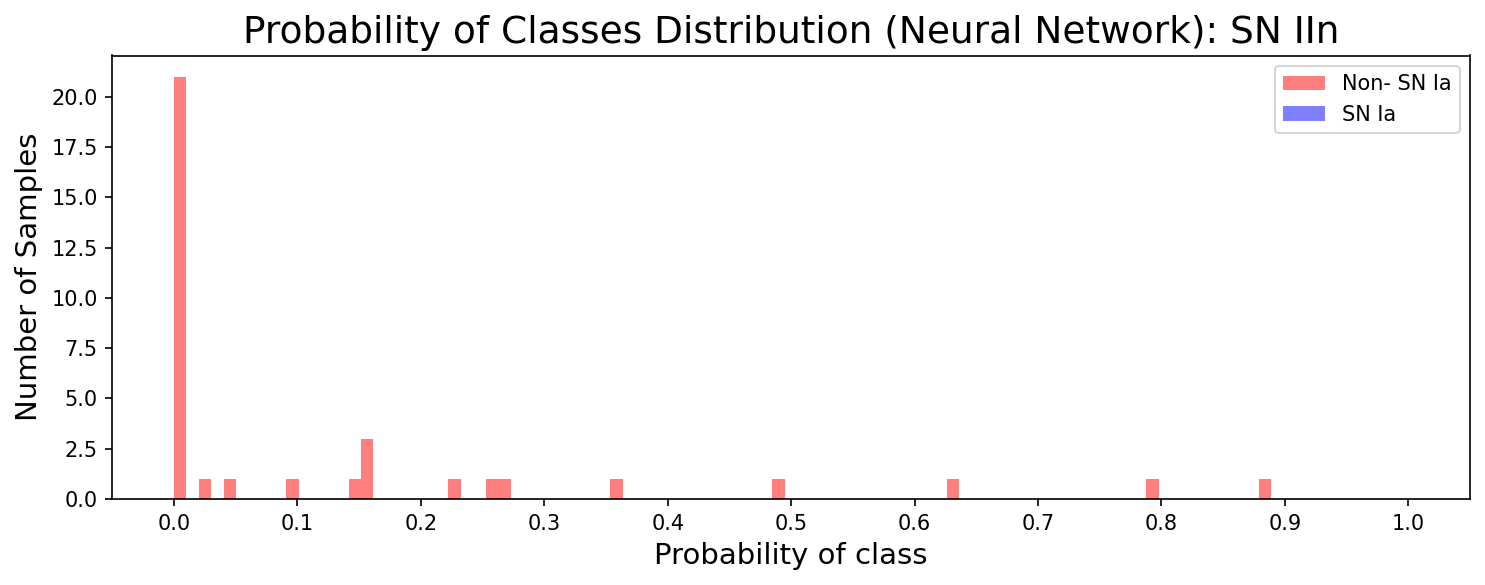

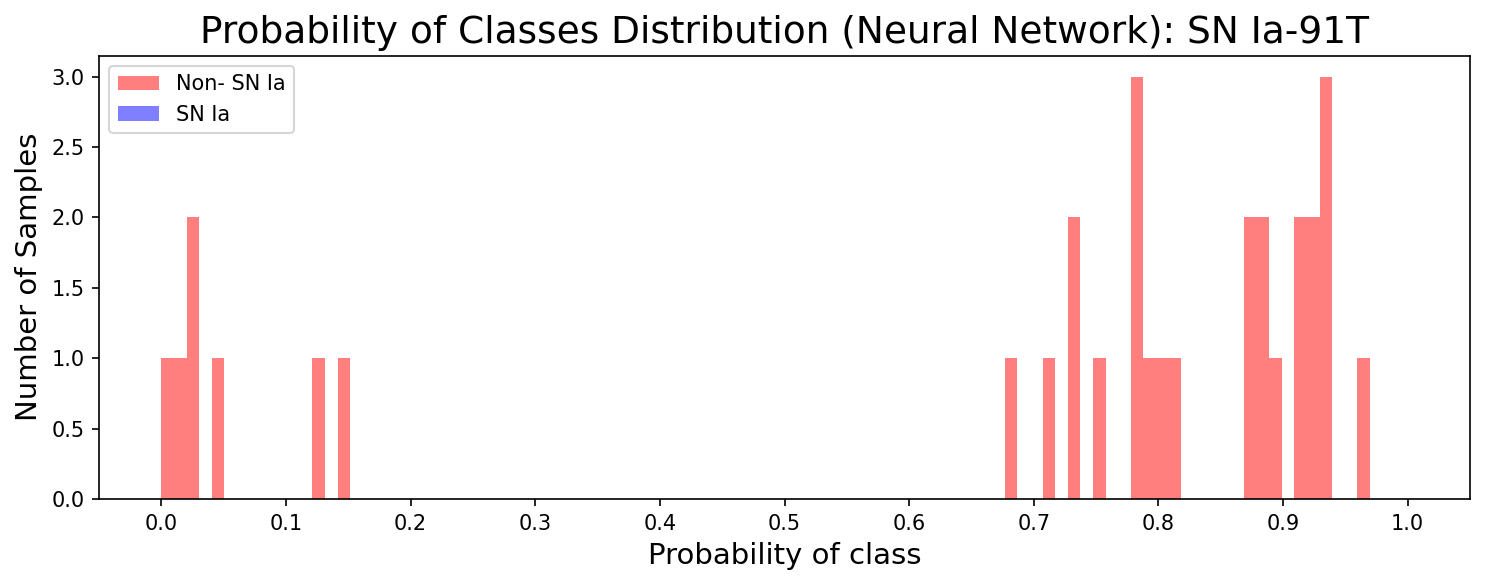

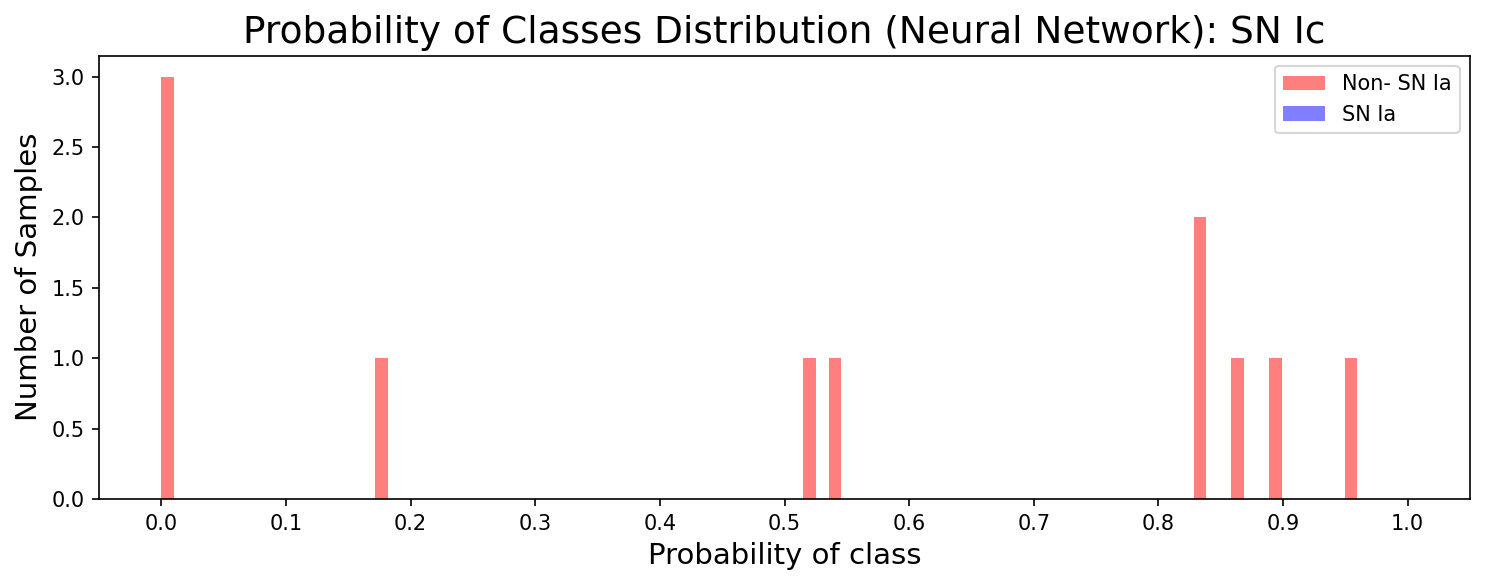

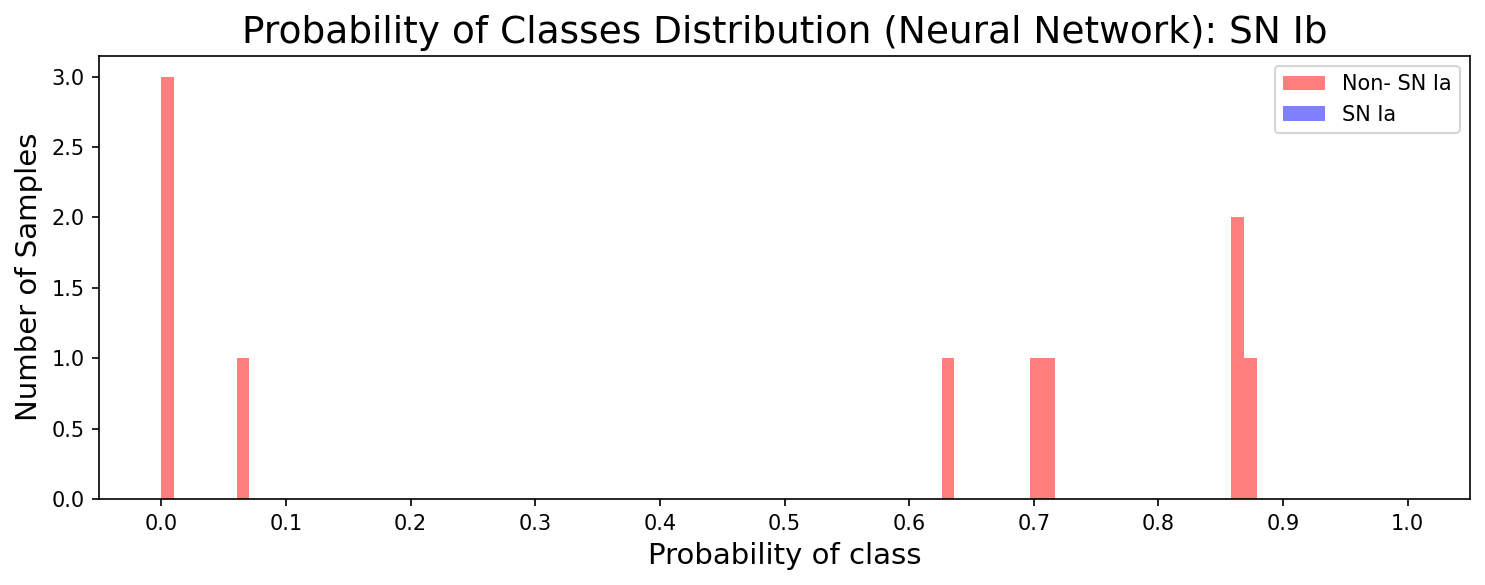

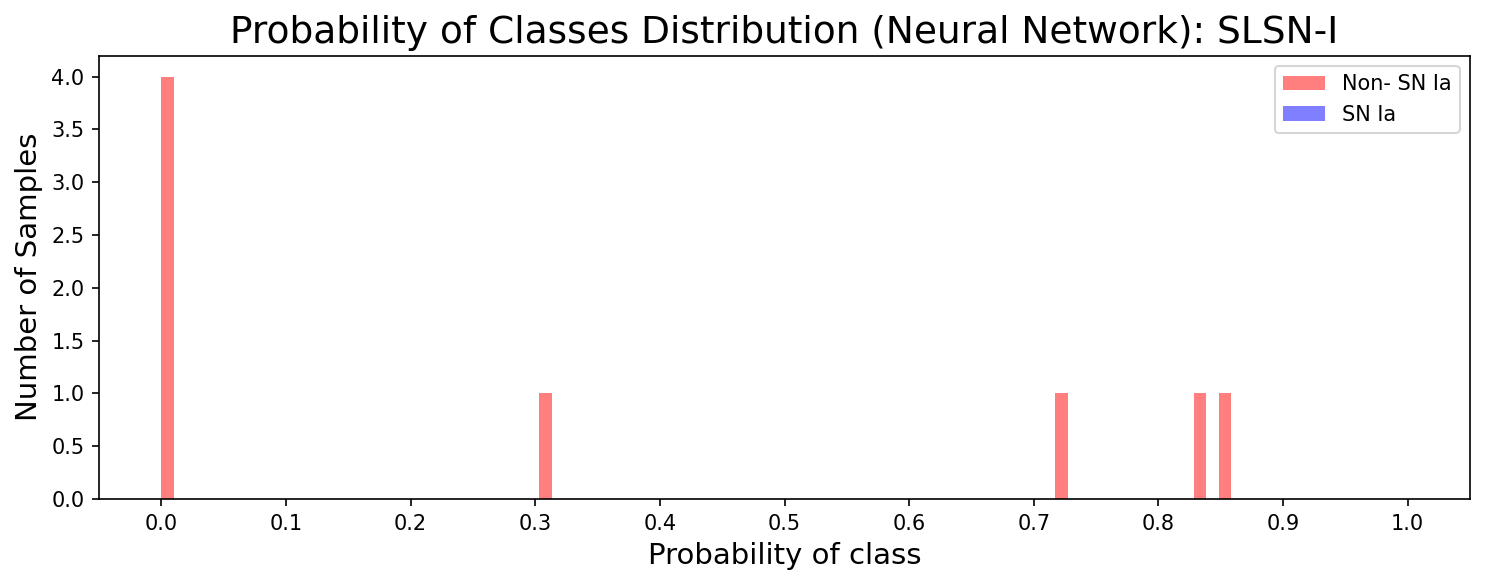

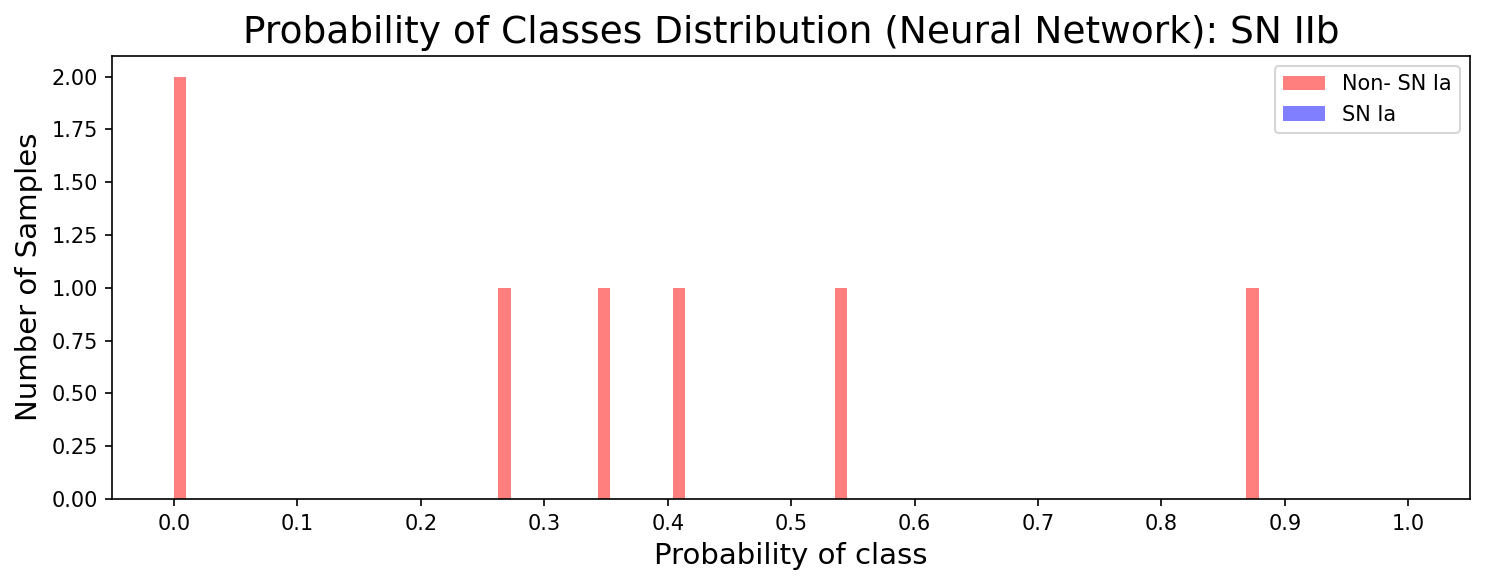

In [48]:
for ct in data.type.value_counts().head(10).index:
    fdata = data[data.type == ct].reset_index(drop=True).copy()
    y_pred_ia = fdata['nn_ia'].values
    
    fig, ax = plt.subplots(figsize=(10, 4), dpi=150)

    ax.hist(y_pred_ia[fdata.is_ia.values == 0].reshape(-1, 1), 
            bins=np.linspace(0, 1, 100),
            density=False,
            label='Non- SN Ia', color='r', alpha=0.5)
    
    ax.hist(y_pred_ia[fdata.is_ia.values == 1].reshape(-1, 1), 
            bins=np.linspace(0, 1, 100),
            density=False,
            label='SN Ia', color='b', alpha=0.5)

    ax.legend(loc='best')
    ax.set_title('Probability of Classes Distribution (Neural Network): {0}'.format(ct), fontsize=18)
    ax.set_xticks(np.linspace(0, 1, 11))
    ax.set_xlabel('Probability of class', fontsize=14)
    ax.set_ylabel('Number of Samples', fontsize=14)
    plt.tight_layout()
    plt.show()


#### Confusion Matrix Analysis SN Ia

In [49]:
TP_data_ia = data[(data.is_ia == 1) & (data.nn_ia >= 0.5)].reset_index(drop=True).copy()
FP_data_ia = data[(data.is_ia == 0) & (data.nn_ia >= 0.5)].reset_index(drop=True).copy()
TN_data_ia = data[(data.is_ia == 0) & (data.nn_ia < 0.5)].reset_index(drop=True).copy()
FN_data_ia = data[(data.is_ia == 1) & (data.nn_ia < 0.5)].reset_index(drop=True).copy()

In [50]:
FN_data_ia.nobs_g.median()

7.0

In [51]:
TP_data_ia.nobs_g.median()

8.0

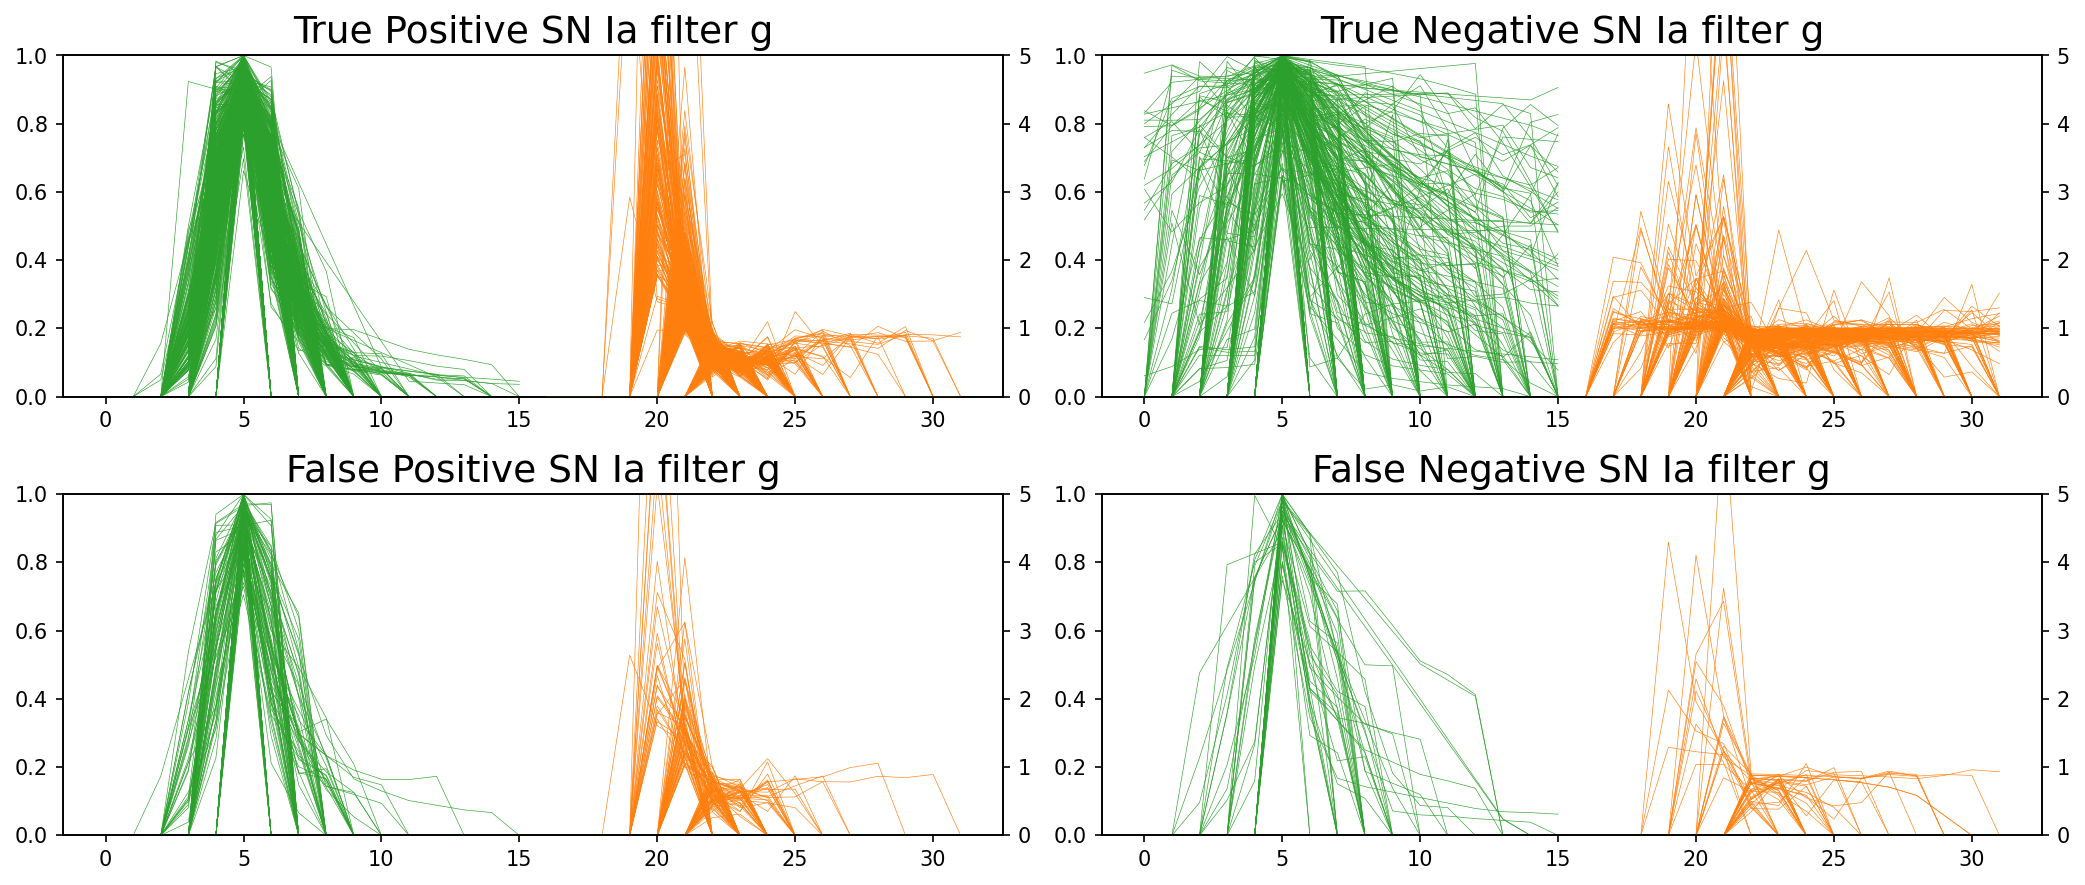

In [52]:
fig, ax = plt.subplots(2, 2, figsize=(14, 6), dpi=150)

# True Positive
ax_twin_tp = ax[0][0].twinx()
for i in range(TP_data_ia.shape[0]):
    x_g = TP_data_ia.reset_index().loc[i, 'x_0':'x_15'].values
    d_g = TP_data_ia.reset_index().loc[i, 'd_0':'d_15'].values
    x = np.arange(16)
    x_d = np.arange(16, 32)
    ax[0][0].plot(x, x_g, color='C2', linewidth=0.3)
    ax_twin_tp.plot(x_d, d_g, color='C1', linewidth=0.3)
    ax[0][0].set_ylim(0., 1)
    ax_twin_tp.set_ylim(0., 5)
    ax[0][0].set_title('True Positive SN Ia filter g', fontsize=18)

# True Negative
ax_twin_tn = ax[0][1].twinx()
for i in range(TN_data_ia.shape[0]):
    x_g = TN_data_ia.reset_index().loc[i, 'x_0':'x_15'].values
    d_g = TN_data_ia.reset_index().loc[i, 'd_0':'d_15'].values
    x = np.arange(16)
    x_d = np.arange(16, 32)
    ax[0][1].plot(x, x_g, color='C2', linewidth=0.3)
    ax_twin_tn.plot(x_d, d_g, color='C1', linewidth=0.3)
    ax[0][1].set_ylim(0., 1)
    ax_twin_tn.set_ylim(0., 5)
    ax[0][1].set_title('True Negative SN Ia filter g', fontsize=18)

# False Positive
ax_twin_fp = ax[1][0].twinx()
for i in range(FP_data_ia.shape[0]):
    x_g = FP_data_ia.reset_index().loc[i, 'x_0':'x_15'].values
    d_g = FP_data_ia.reset_index().loc[i, 'd_0':'d_15'].values
    x = np.arange(16)
    x_d = np.arange(16, 32)
    ax[1][0].plot(x, x_g, color='C2', linewidth=0.3)
    ax_twin_fp.plot(x_d, d_g, color='C1', linewidth=0.3)
    ax[1][0].set_ylim(0., 1)
    ax_twin_fp.set_ylim(0., 5)
    ax[1][0].set_title('False Positive SN Ia filter g', fontsize=18)

# False Negative
ax_twin_fn = ax[1][1].twinx()
for i in range(FN_data_ia.shape[0]):
    x_g = FN_data_ia.reset_index().loc[i, 'x_0':'x_15'].values
    d_g = FN_data_ia.reset_index().loc[i, 'd_0':'d_15'].values
    x = np.arange(16)
    x_d = np.arange(16, 32)
    ax[1][1].plot(x, x_g, color='C2', linewidth=0.3)
    ax_twin_fn.plot(x_d, d_g, color='C1', linewidth=0.3)
    ax[1][1].set_ylim(0., 1)
    ax_twin_fn.set_ylim(0., 5)
    ax[1][1].set_title('False Negative SN Ia filter g', fontsize=18)

plt.tight_layout()
plt.show()


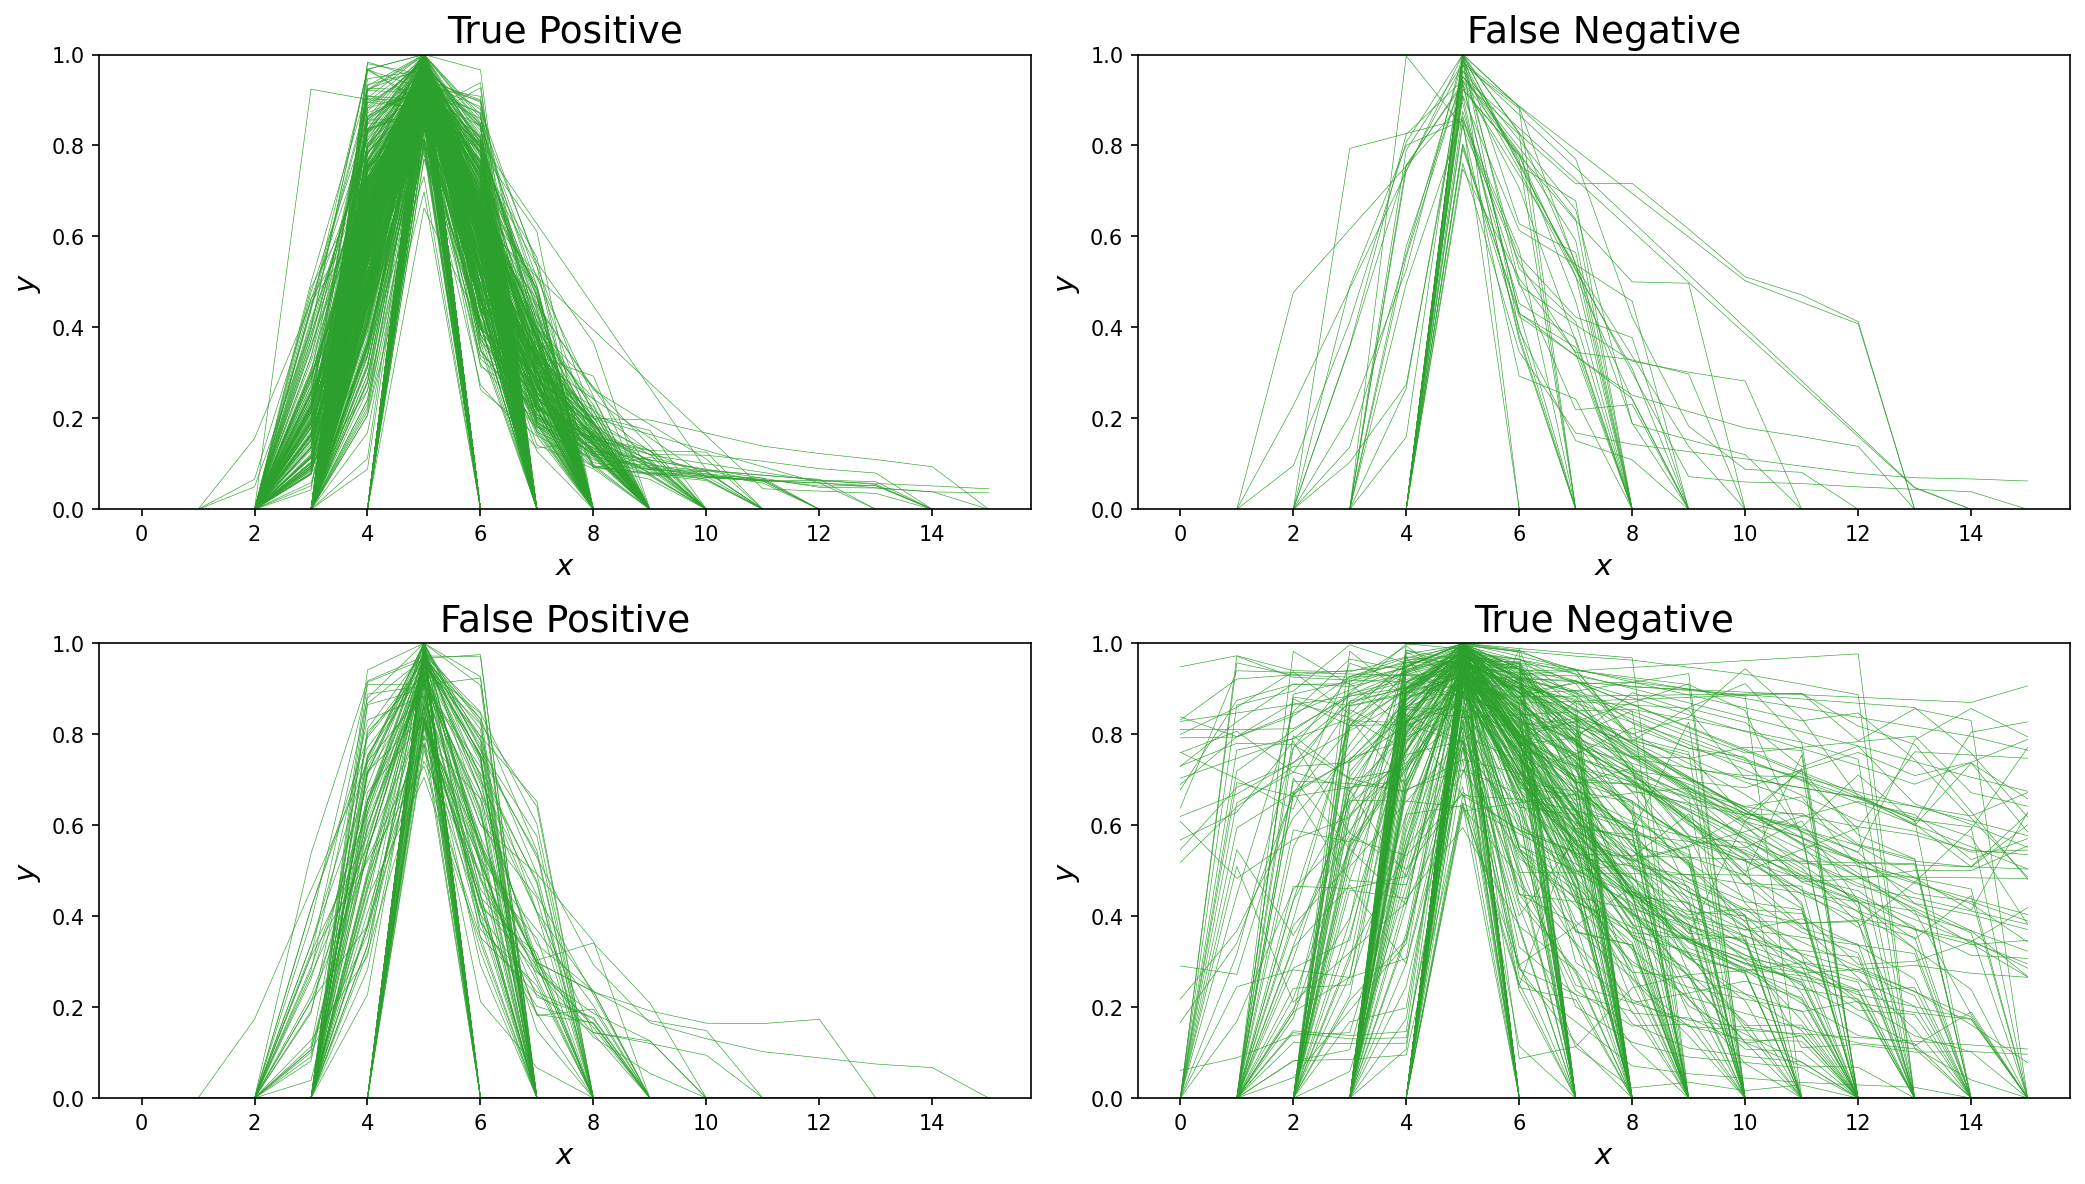

In [53]:
# True Positive - is_ia (r)
fig, ax = plt.subplots(2, 2, figsize=(14, 8), dpi=150)

for i in range(TP_data_ia.shape[0]):
    y = TP_data_ia.reset_index().loc[i, 'x_0':'x_15'].values
    x = np.arange(len(y))
    ax[0][0].plot(x, y, color='C2', linewidth=0.3)
    ax[0][0].set_ylim(0., 1)
    ax[0][0].set_title('True Positive', fontsize=18)
    
for i in range(FN_data_ia.shape[0]):
    y = FN_data_ia.reset_index().loc[i, 'x_0':'x_15'].values
    x = np.arange(len(y))
    ax[0][1].plot(x, y, color='C2', linewidth=0.3)
    ax[0][1].set_ylim(0., 1)
    ax[0][1].set_title('False Negative', fontsize=18)
    
for i in range(FP_data_ia.shape[0]):
    y = FP_data_ia.reset_index().loc[i, 'x_0':'x_15'].values
    x = np.arange(len(y))
    ax[1][0].plot(x, y, color='C2', linewidth=0.3)
    ax[1][0].set_ylim(0., 1)
    ax[1][0].set_title('False Positive', fontsize=18)
    
for i in range(TN_data_ia.shape[0]):
    y = TN_data_ia.reset_index().loc[i, 'x_0':'x_15'].values
    x = np.arange(len(y))
    ax[1][1].plot(x, y, color='C2', linewidth=0.3)
    ax[1][1].set_ylim(0., 1)
    ax[1][1].set_title('True Negative', fontsize=18)
    
ax[0][0].set_xlabel('$x$', fontsize=14)
ax[0][0].set_ylabel('$y$', fontsize=14)
ax[0][1].set_xlabel('$x$', fontsize=14)
ax[0][1].set_ylabel('$y$', fontsize=14)
ax[1][0].set_xlabel('$x$', fontsize=14)
ax[1][0].set_ylabel('$y$', fontsize=14)
ax[1][1].set_xlabel('$x$', fontsize=14)
ax[1][1].set_ylabel('$y$', fontsize=14)

plt.tight_layout()
plt.show()


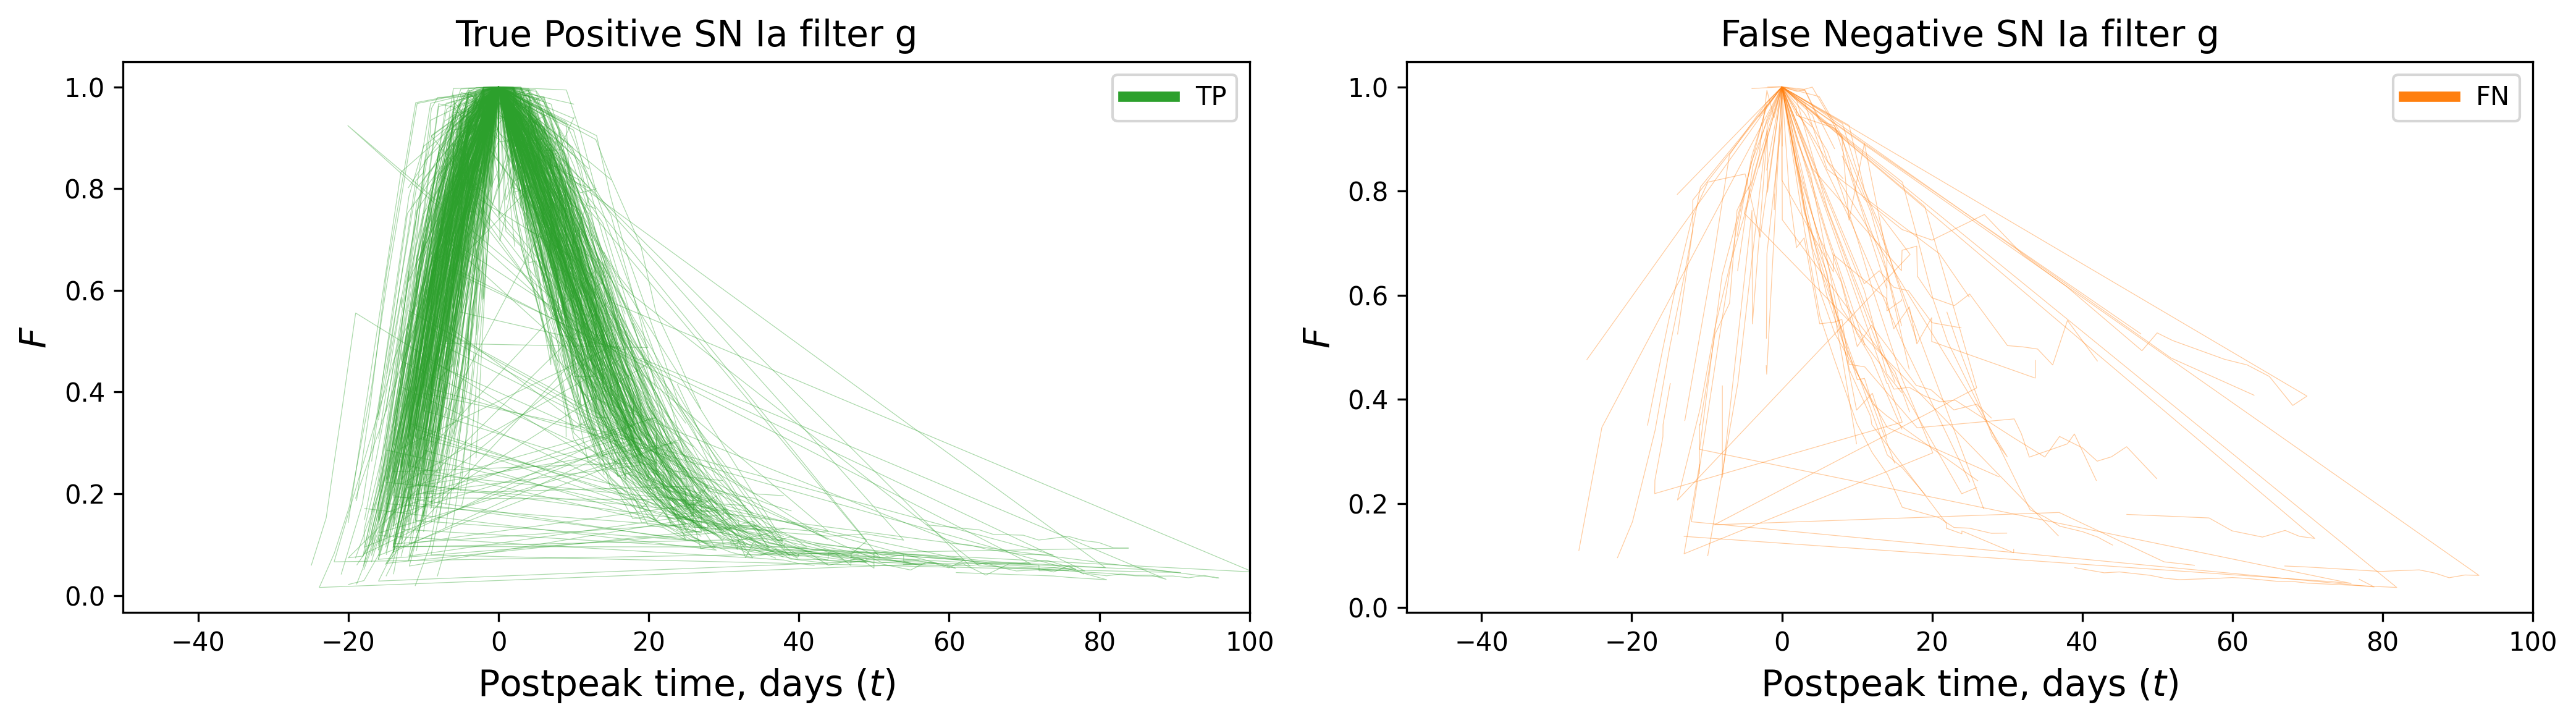

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4), dpi=300)
from matplotlib.lines import Line2D
# Define custom lines for the legend
custom_lines = [Line2D([0], [0], color='C2', lw=4),
                Line2D([0], [0], color='C1', lw=4)]

# True Positive - TP_data
for i in range(TP_data_ia.shape[0]):
    x = TP_data_ia.reset_index().loc[i, 'x_shifted_g']
    y = TP_data_ia.reset_index().loc[i, 'curve_g_normalized']
    ax[0].plot(x, y, alpha=0.4, color='C2', linewidth=0.3)
    
ax[0].set_title('True Positive SN Ia filter g', fontsize=14)
ax[0].set_ylabel('$F$', fontsize=14)
ax[0].set_xlabel('Postpeak time, days $(t)$', fontsize=14)
ax[0].set_xlim(-50, 100)
ax[0].legend([custom_lines[0]], ['TP'], loc='upper right')

# False Negative - FN_data
for i in range(FN_data_ia.shape[0]):
    x = FN_data_ia.reset_index().loc[i, 'x_shifted_g']
    y = FN_data_ia.reset_index().loc[i, 'curve_g_normalized']
    ax[1].plot(x, y, alpha=0.4, color='C1', linewidth=0.3)
    
ax[1].set_title('False Negative SN Ia filter g', fontsize=14)
ax[1].set_ylabel('$F$', fontsize=14)
ax[1].set_xlabel('Postpeak time, days $(t)$', fontsize=14)
ax[1].set_xlim(-50, 100)
ax[1].legend([custom_lines[1]], ['FN'], loc='upper right')

plt.tight_layout()
#plt.savefig(fname='Gambar/TP_FN_confusion_g.png', dpi=300, format='png')
plt.show()


In [56]:
data.to_csv('TA_Azzidny/HASIL/DataHasilML_g_NoUnclass.csv',index=False)